In [1]:
# Check the GPU
!nvidia-smi

Wed May  7 12:23:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             13W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/refs/heads/main/examples/text_to_image/textual_inversion_sdxl.py

--2025-05-07 12:11:52--  https://raw.githubusercontent.com/huggingface/diffusers/refs/heads/main/examples/text_to_image/train_text_to_image_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56277 (55K) [text/plain]
Saving to: ‘train_text_to_image_lora_sdxl.py’

train_text_to_image 100%[===================>]  54.96K  --.-KB/s    in 0.01s   

2025-05-07 12:11:52 (4.38 MB/s) - ‘train_text_to_image_lora_sdxl.py’ saved [56277/56277]



In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
from huggingface_hub import snapshot_download

local_dir = "./itay/"
snapshot_download(
    "huyhuung/Itay",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

'/kaggle/working/itay'

In [6]:
import shutil
shutil.rmtree("itay/.cache", ignore_errors=True)

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

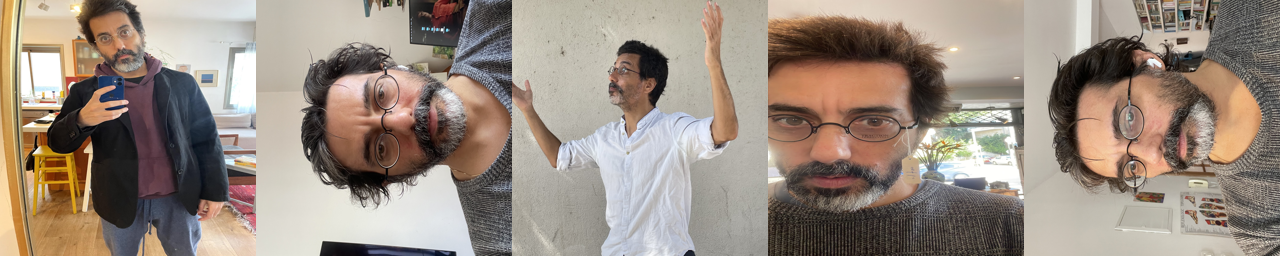

In [8]:
import glob

# change path to display images from your local dir
img_paths = "./itay/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

In [72]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [73]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./itay/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

In [74]:
import json

caption_prefix = "a photo of TOK person, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [75]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

In [76]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [77]:
!pip install peft --upgrade

In [ ]:
#!/usr/bin/env bash
accelerate launch textual_inversion_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0"\
  --train_data_dir="./itay" \
  --learnable_property="object"
  --placeholder_token="<itay>" \
  --initializer_token="man" \
  --mixed_precision="bf16" \
  --resolution=768 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=500 \
  --learning_rate=5.0e-04 \
  --scale_lr \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --save_as_full_pipeline \
  --output_dir="./textual_inversion_itay_sdxl"

2025-05-07 12:24:23.760405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 12:24:23.760583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746620663.787797     632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746620663.787825     633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746620663.795157     632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
E0000 00:00:1746620663.795247     633 cuda_blas.cc:1

In [10]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "itay_SDXL_textual_inversion" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [ ]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from textual_inversion_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

2025-05-07 13:49:09.405521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746625749.429392     542 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746625749.436659     542 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/186M [00:00<?, ?B/s]

events.out.tfevents.1746620704.8f3a9c335860.632.0:   0%|          | 0.00/31.8k [00:00<?, ?B/s]

events.out.tfevents.1746620704.8f3a9c335860.632.1:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/huyhuung/itay_SDXL_LoRA/commit/92ae65969a29b6de2cd2b3444c2d6ccbdea62663', commit_message='End of training', commit_description='', oid='92ae65969a29b6de2cd2b3444c2d6ccbdea62663', pr_url=None, repo_url=RepoUrl('https://huggingface.co/huyhuung/itay_SDXL_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='huyhuung/itay_SDXL_LoRA'), pr_revision=None, pr_num=None)

In [13]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/186M [00:00<?, ?B/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [ ]:
image.save("/kaggle/working/itay_textual_inversion_Lora11.png", format="PNG")

In [ ]:
pos = "(wide shot) of analog style modelshoot style 8k close up linkedin profile picture of TOK person, professional jack suite, photo-realistic, 4k, high-resolution image, workplace settings, man, high-definition, symmetrical eyes, highly detailed, masterpiece, best quality, extremely detailed 8k wallpaper, masterpiece, best quality."
neg = "asian, multiple heads, elongated body, double image, nsfw, naked, nude, porn, deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, anime, text, close-up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra/missing limbs, mutated/deformed body parts, poorly drawn face/hands, blurry, bad anatomy/proportions, disfigured, gross proportions, malformed limbs, fused/too many fingers, long neck"
image = pipe(prompt=pos, negative_prompt=neg, num_inference_steps=40, guidance_scale=7.5).images[0]
image

In [58]:
pwd

'/kaggle/working'